# Metadata

```yaml
Course:    DS 5001 
Module:    08 Lab
Topic:     LDA Topic Contiguity
Author:    R.C. Alvarado
Date:      09 March 2023
```

**Purpose:** To explore topc contiguity in correlational and informational vector spaces.

# Set Up

## Config

In [1]:
data_in = '../data/output'
data_out = '../data/output'
data_prefix = 'austen-melville'
local_lib = "../lib/"
colors = "YlGnBu"
n_topics = 40
OHCO = ['book_id','chap_num']

## Imports

In [2]:
import pandas as pd
import numpy as np
import plotly_express as px

In [3]:
import sys; sys.path.append(local_lib)
from hac import HAC

# Get the Data

In [4]:
DOCS = pd.read_csv(f"{data_in}/{data_prefix}-LDA_DOCS-chaps.csv").set_index(OHCO)
TOPICS = pd.read_csv(f"{data_in}/{data_prefix}-LDA_TOPICS-{n_topics}.csv").set_index('topic_id')
THETA = pd.read_csv(f"{data_in}/{data_prefix}-LDA_THETA-{n_topics}.csv").set_index(OHCO)
PHI = pd.read_csv(f"{data_in}/{data_prefix}-LDA_PHI-{n_topics}.csv").set_index('topic_id')

In [5]:
LIB = pd.read_csv(f'{data_in}/{data_prefix}-LIB_FIXED.csv').set_index('book_id')

Create a short label for each author for display purposes.

In [6]:
LIB['author_key'] = LIB.author.str.split(', ').str[0].str.lower()

# Correlation

One way to think of topic contiguity is as the **statistical correlation between topic pairs**. 

- We can get the correlation of topics from either the `THETA` or `PHI` tables.

- In the first case, the **embeddings** are documents, in the second they are words.

We use **Kendall's** method because it is non-parametric.

Below, we create a table of topic pairs $X$ and add two correlation features, one for each embedding.

In [36]:
# THETA.corr(method='kendall').stack().to_frame('corr_theta')

In [7]:
X = pd.concat([THETA.corr(method='kendall').stack().to_frame('corr_theta'), 
               PHI.T.corr(method='kendall').stack().to_frame('corr_phi')], axis=1)
X.index.names = ['topic_id_x','topic_id_y']
X = X.query("topic_id_x < topic_id_y") 
X['corr_mean'] = (X.corr_theta + X.corr_phi) / 2

Add topic labels to the table for display purposes.

In [8]:
X = X.reset_index()
X['label_x'] = X.topic_id_x.map(TOPICS.label)
X['label_y'] = X.topic_id_y.map(TOPICS.label)
X = X.set_index(['topic_id_x','topic_id_y'])

Correlate the correlations.

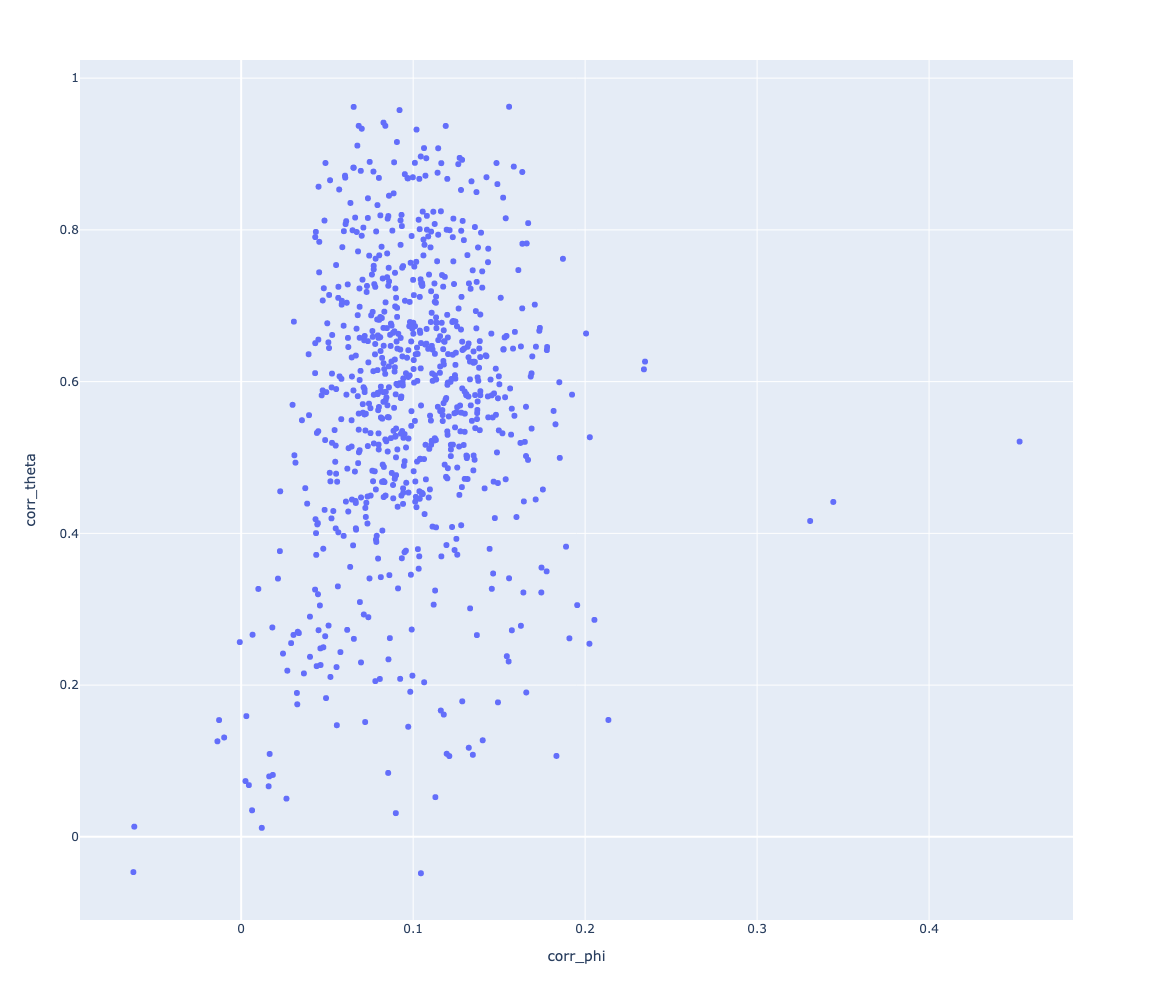

In [112]:
px.scatter(X, 'corr_phi', 'corr_theta', hover_data=['label_x', 'label_y'], width=600, height=1000)

In [37]:
# X.sort_values('corr_mean')[['corr_theta','corr_phi','corr_mean']].plot(figsize=(10,5), rot=45);

In [11]:
X.sort_values('corr_phi', ascending=False)[['corr_phi', 'label_x','label_y']]\
    .head(10).style.background_gradient(cmap=colors)

In [38]:
X.sort_values('corr_phi', ascending=True)[['corr_phi', 'label_x','label_y']]\
    .head(10).style.background_gradient(cmap=colors)

,,corr_phi,label_x,label_y
topic_id_x,topic_id_y,,,
T30,T38,-0.062670,"T30 sea, ship, deck, night, man, sail, wind, time, hand","T38 time, day, house, thing, room, sister, man, pleasure, home"
T20,T30,-0.062144,"T20 time, feelings, heart, mind, moment, letter, happiness, subject, friend","T30 sea, ship, deck, night, man, sail, wind, time, hand"
T02,T38,-0.013800,"T02 sea, air, fish, round, day, trees, groves, water, flowers","T38 time, day, house, thing, room, sister, man, pleasure, home"
T05,T30,-0.012852,"T05 father, mother, family, years, brother, time, aunt, child, daughter","T30 sea, ship, deck, night, man, sail, wind, time, hand"
T20,T29,-0.009889,"T20 time, feelings, heart, mind, moment, letter, happiness, subject, friend","T29 man, men, war, gun, guns, deck, jacket, man war, wars"
T21,T30,-0.000805,"T21 man, barber, gentleman, men, sort, world, time, life, person","T30 sea, ship, deck, night, man, sail, wind, time, hand"
T14,T20,0.002518,"T14 men, time, world, things, years, people, land, times, man","T20 time, feelings, heart, mind, moment, letter, happiness, subject, friend"
T02,T20,0.003006,"T02 sea, air, fish, round, day, trees, groves, water, flowers","T20 time, feelings, heart, mind, moment, letter, happiness, subject, friend"
T12,T20,0.004471,"T12 sea, time, land, water, ship, air, day, sight, ships","T20 time, feelings, heart, mind, moment, letter, happiness, subject, friend"


# Gravity

Topic gravity is a way to measure the weight of a **pair** in similarity space.

We will use this value in our visualizations.

Recall that gravity $G = \large \frac{M_1 M_2}{d^2}$.

In [13]:
from scipy.spatial.distance import pdist

In [107]:
dist_metric = 'cityblock'
# dist_metric = 'cosine'
# dist_metric = 'jensenshannon'
X['dist_theta'] = pdist(THETA.T, dist_metric)
X['dist_phi'] = pdist(PHI, dist_metric)

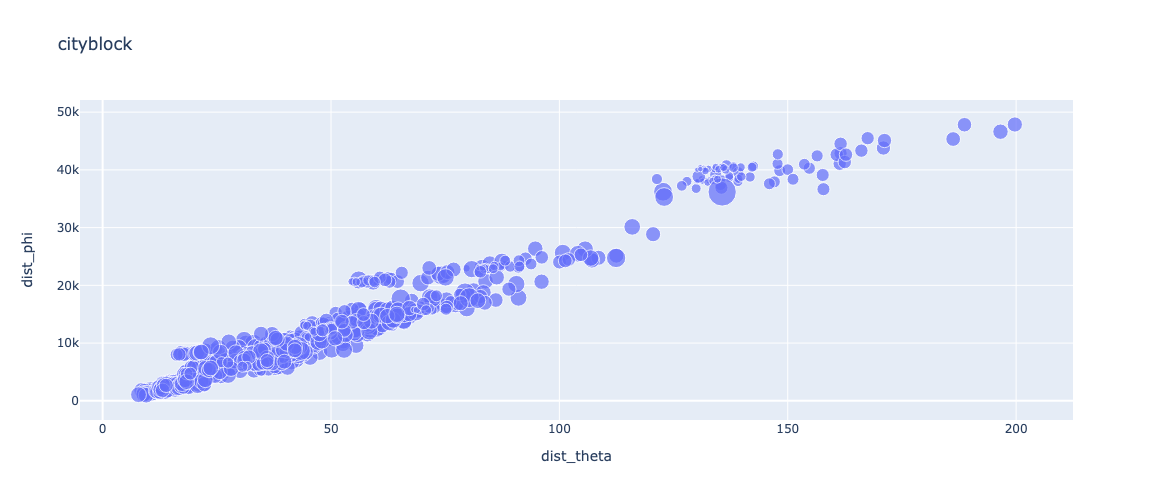

In [109]:
px.scatter(X, 'dist_theta', 'dist_phi', title=dist_metric, size='gravity', width=500, height=500, hover_data=['label_x','label_y'])

In [89]:
X = X.reset_index()
X['weight_x'] = X.topic_id_x.map(TOPICS.doc_weight_sum)
X['weight_y'] = X.topic_id_y.map(TOPICS.doc_weight_sum)
X['gravity'] = X.weight_x * X.weight_y / X.dist_theta**2
X = X.set_index(['topic_id_x','topic_id_y'])

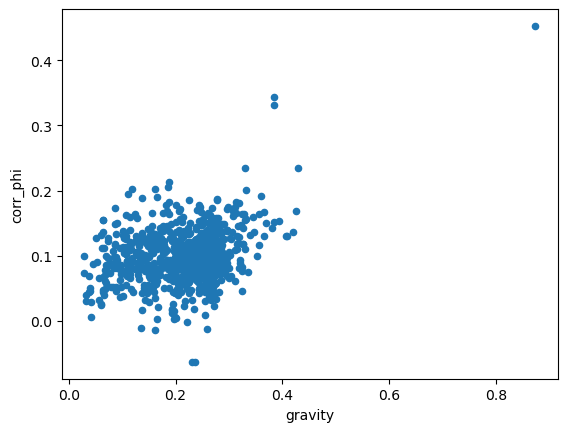

In [90]:
X.plot.scatter('gravity','corr_phi');

In [91]:
X.sort_values('gravity', ascending=False)[['gravity', 'label_x','label_y']]\
    .head(10).style.background_gradient(cmap=colors)

In [92]:
X.sort_values('gravity', ascending=True)[['gravity', 'label_x','label_y']]\
    .head(10).style.background_gradient(cmap=colors)

Look at correlations and gravity.

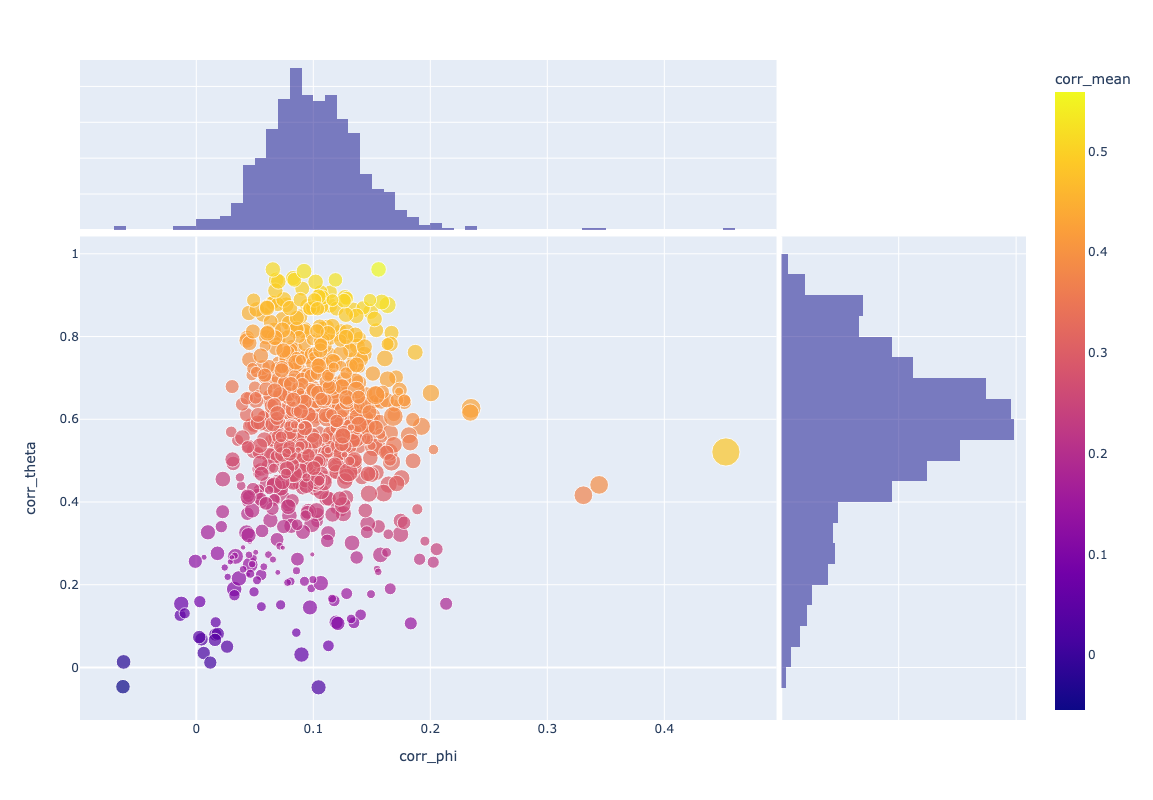

In [93]:
px.scatter(X.reset_index(), 'corr_phi', 'corr_theta', 
           hover_data=['label_x','label_y'],
           size='gravity', 
           color='corr_mean', marginal_x='histogram', marginal_y='histogram',
           height=800, width=1000, 
           log_x=False, log_y=False)

# Mutual Information

Mutual informtion $I$ obeys the following formula:

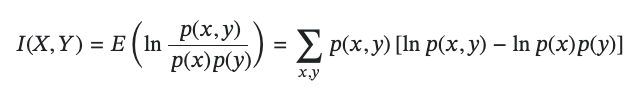

It is the expectation of pointwise mutual information $i(x,y)$.

$\Large i(x, y) = \Large log(\frac{p(x,y)}{p(x)p(y)})$

Per [Bouma 2009](https://svn.spraakdata.gu.se/repos/gerlof/pub/www/Docs/npmi-pfd.pdf), we normalize $i(x,y)$ to avoid ovder-valuing rare co-occurrences.

$\Large i_n(x,y) = \Large \frac{i(x,y)}{log(\frac{1}{p(x,y)})}$

In [21]:
weight_thresh = .2

In [22]:
THETA2 = THETA[THETA >= weight_thresh].stack().to_frame('topic_weight').rename_axis(['book_id','chap_num','topic_id']).reset_index()

In [23]:
TOPICS['p'] = THETA2.topic_id.value_counts(normalize=True)

In [24]:
TPAIRS = THETA2.merge(THETA2, on=OHCO).value_counts(['topic_id_x', 'topic_id_y']).to_frame('n').query("topic_id_x < topic_id_y")
TPAIRS = TPAIRS.sort_index().reset_index()

TPAIRS['p_xy'] = TPAIRS.n / TPAIRS.n.sum()
TPAIRS['p_x'] = TPAIRS.topic_id_x.map(TOPICS.p)
TPAIRS['p_y'] = TPAIRS.topic_id_y.map(TOPICS.p)
TPAIRS['p_yGx'] = TPAIRS.p_xy / TPAIRS.p_x
TPAIRS['p_xGy'] = TPAIRS.p_xy / TPAIRS.p_y
TPAIRS['pwmi'] = np.log2(TPAIRS.p_xy / (TPAIRS.p_x * TPAIRS.p_y))
TPAIRS['mi'] = TPAIRS.pwmi * TPAIRS.p_xy
TPAIRS['nmi'] = TPAIRS.pwmi / np.log2(1/TPAIRS.p_xy) # Normalized point-wise mutual information (Bouma 2009) https://svn.spraakdata.gu.se/repos/gerlof/pub/www/Docs/npmi-pfd.pdf 

TPAIRS = TPAIRS.set_index(['topic_id_x', 'topic_id_y'])
TPAIRS = TPAIRS.join(X)

In [46]:
# TPAIRS.sort_values('nmi', ascending=False).head() #.style.background_gradient(cmap=colors)

In [26]:
TPAIRS.describe().T

,count,mean,std,min,25%,50%,75%,max
n,221.0,3.932127,11.466945,1.000000,1.000000,1.000000,3.000000,154.000000
p_xy,221.0,0.004525,0.013196,0.001151,0.001151,0.001151,0.003452,0.177215
p_x,221.0,0.030049,0.023545,0.002134,0.016009,0.027748,0.039488,0.121665
p_y,221.0,0.041364,0.038064,0.002134,0.011206,0.025614,0.068303,0.135539
p_yGx,221.0,0.174523,0.232498,0.009458,0.046880,0.089854,0.215650,1.456584
p_xGy,221.0,0.141807,0.149165,0.008490,0.044927,0.098023,0.196046,1.307485
pwmi,221.0,1.942321,1.458802,-2.375854,1.184558,2.077319,3.026402,5.980598
mi,221.0,0.011895,0.044978,-0.005257,0.001727,0.003558,0.008104,0.607106
nmi,221.0,0.238595,0.198671,-0.260659,0.130788,0.241200,0.349539,1.372286
corr_theta,221.0,0.496958,0.154702,-0.047978,0.421536,0.516462,0.606712,0.815294


We compare mutual information to correlation.

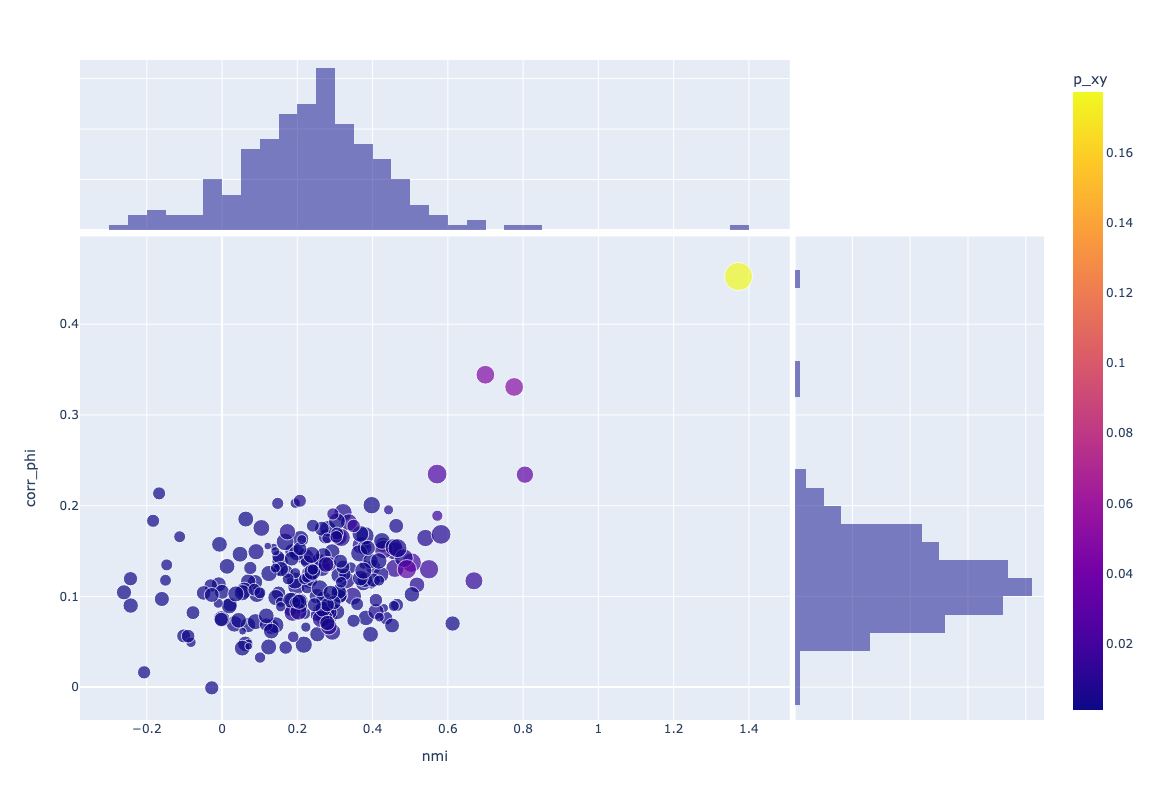

In [81]:
px.scatter(TPAIRS.reset_index(), 'nmi', 'corr_phi', 
           hover_data=['label_x','label_y'],
           size='gravity', 
           color='p_xy', marginal_x='histogram', marginal_y='histogram',
           height=800, width=1000, 
           log_x=False, log_y=False)

# Graph

In [28]:
from graphviz import Graph

In [29]:
TOPICS['short_label'] = TOPICS.label.apply(lambda x: x.split()[0] + r"\n" + " ".join(x.split(", ")[1:4]) + r"\n" + " ".join(x.split(", ")[4:8]) )

In [49]:
corr_thresh = .1
nmi_thresh = .25

In [71]:
EDGES = []

# By correlation
EDGES.append(TPAIRS[TPAIRS.corr_phi > corr_thresh].index.to_list())

# By mutual information
EDGES.append(TPAIRS[TPAIRS.nmi > nmi_thresh].index.to_list())

# By both
EDGES.append(TPAIRS[(TPAIRS.corr_phi > corr_thresh) & (TPAIRS.nmi > nmi_thresh)].index.to_list())

In [72]:
def draw_graph(edge_num = 0):
    G = Graph('tm', node_attr={'shape':'rectangle'})
    NODES = set()
    for src, dst in EDGES[edge_num]:
        NODES.add(src)
        NODES.add(dst)
        G.edge(src, dst)
    for node in sorted(NODES):
        G.node(node, TOPICS.loc[node].short_label)
    G.view(f"tm{edge_num}")

In [73]:
draw_graph(0)
draw_graph(1)
draw_graph(2)